# 开发 AI 应用

未来，AI 算法在日常生活中的应用将越来越广泛。例如，你可能想要在智能手机应用中包含图像分类器。为此，在整个应用架构中，你将使用一个用成百上千个图像训练过的深度学习模型。未来的软件开发很大一部分将是使用这些模型作为应用的常用部分。

在此项目中，你将训练一个图像分类器来识别不同的花卉品种。可以想象有这么一款手机应用，当你对着花卉拍摄时，它能够告诉你这朵花的名称。在实际操作中，你会训练此分类器，然后导出它以用在你的应用中。我们将使用[此数据集](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)，其中包含 102 个花卉类别。你可以在下面查看几个示例。 

<img src='assets/Flowers.png' width=500px>

该项目分为多个步骤：

* 加载和预处理图像数据集
* 用数据集训练图像分类器
* 使用训练的分类器预测图像内容

我们将指导你完成每一步，你将用 Python 实现这些步骤。

完成此项目后，你将拥有一个可以用任何带标签图像的数据集进行训练的应用。你的网络将学习花卉，并成为一个命令行应用。但是，你对新技能的应用取决于你的想象力和构建数据集的精力。例如，想象有一款应用能够拍摄汽车，告诉你汽车的制造商和型号，然后查询关于该汽车的信息。构建你自己的数据集并开发一款新型应用吧。

首先，导入你所需的软件包。建议在代码开头导入所有软件包。当你创建此 notebook 时，如果发现你需要导入某个软件包，确保在开头导入该软件包。

In [2]:
# 导入必要的软件包和模块
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
import os
from PIL import Image
import json
import seaborn as sb
import matplotlib.pyplot as plt

## 加载数据

在此项目中，你将使用 `torchvision` 加载数据（[文档](http://pytorch.org/docs/master/torchvision/transforms.html#)）。数据应该和此 notebook 一起包含在内，否则你可以[在此处下载数据](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz)。数据集分成了三部分：训练集、验证集和测试集。对于训练集，你需要变换数据，例如随机缩放、剪裁和翻转。这样有助于网络泛化，并带来更好的效果。你还需要确保将输入数据的大小调整为 224x224 像素，因为预训练的网络需要这么做。

验证集和测试集用于衡量模型对尚未见过的数据的预测效果。对此步骤，你不需要进行任何缩放或旋转变换，但是需要将图像剪裁到合适的大小。

对于所有三个数据集，你都需要将均值和标准差标准化到网络期望的结果。均值为 `[0.485, 0.456, 0.406]`，标准差为 `[0.229, 0.224, 0.225]`。这样使得每个颜色通道的值位于 -1 到 1 之间，而不是 0 到 1 之间。

In [3]:
# DONE: Define your transforms for the training, validation, and testing sets
# train_dir = 'train'
# valid_dir = 'valid'
# test_dir = 'test'
expect_mean = [0.485, 0.456, 0.406]
expect_std = [0.229, 0.224, 0.225]
resize = 256
image_size = 224
data_dir = 'flowers'

data_transforms = {                        #指定数据处理方式
    'train': transforms.Compose([                 #训练集
        transforms.RandomResizedCrop(image_size), #随机裁剪
        transforms.RandomHorizontalFlip(), #随机翻转
        transforms.RandomRotation(30),     #随机旋转
        transforms.ToTensor(),             #将 PIL.Image/numpy.ndarray 数据进转化为torch.FloadTensor，并归一化到[0, 1.0]
        transforms.Normalize(expect_mean, expect_std)]), #将均值和标准差标准化到网络期望的结果
    
    'valid': transforms.Compose([                 #验证集
        transforms.Resize(resize),
        transforms.CenterCrop(image_size),        #裁剪至合适大小
        transforms.ToTensor(),
        transforms.Normalize(expect_mean, expect_std)]),
    
    'test': transforms.Compose([                  #测试集
        transforms.Resize(resize),
        transforms.CenterCrop(image_size), 
        transforms.ToTensor(),
        transforms.Normalize(expect_mean, expect_std)])
                }

# TODO: Load the datasets with ImageFolder
#指定数据集路径
image_datasets = {x: datasets.ImageFolder(
                    os.path.join(data_dir, x),
                    transform = data_transforms[x])
                    for x in list(data_transforms.keys())}


# TODO: Using the image datasets and the trainforms, define the dataloaders
#将数据集随机分批训练
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],     
                                            batch_size=32, 
                                            shuffle=True) 
                                            for x in list(data_transforms.keys())}
#数据集的大小
dataset_sizes = {                 
        x: len(dataloaders[x].dataset) 
        for x in list(data_transforms.keys())} 

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #如果 GPU 模式可行，使用 GPU，否则使用 CPU

### 标签映射

你还需要加载从类别标签到类别名称的映射。你可以在文件 `cat_to_name.json` 中找到此映射。它是一个 JSON 对象，可以使用 [`json` 模块](https://docs.python.org/2/library/json.html)读取它。这样可以获得一个从整数编码的类别到实际花卉名称的映射字典。

In [6]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# 构建和训练分类器

数据准备好后，就开始构建和训练分类器了。和往常一样，你应该使用 `torchvision.models` 中的某个预训练模型获取图像特征。使用这些特征构建和训练新的前馈分类器。

这部分将由你来完成。如果你想与他人讨论这部分，欢迎与你的同学讨论！你还可以在论坛上提问或在工作时间内咨询我们的课程经理和助教导师。

请参阅[审阅标准](https://review.udacity.com/#!/rubrics/1663/view)，了解如何成功地完成此部分。你需要执行以下操作：

* 加载[预训练的网络](http://pytorch.org/docs/master/torchvision/models.html)（如果你需要一个起点，推荐使用 VGG 网络，它简单易用）
* 使用 ReLU 激活函数和丢弃定义新的未训练前馈网络作为分类器
* 使用反向传播训练分类器层，并使用预训练的网络获取特征
* 跟踪验证集的损失和准确率，以确定最佳超参数

我们在下面为你留了一个空的单元格，但是你可以使用多个单元格。建议将问题拆分为更小的部分，并单独运行。检查确保每部分都达到预期效果，然后再完成下个部分。你可能会发现，当你实现每部分时，可能需要回去修改之前的代码，这很正常！

训练时，确保仅更新前馈网络的权重。如果一切构建正确的话，验证准确率应该能够超过 70%。确保尝试不同的超参数（学习速率、分类器中的单元、周期等），寻找最佳模型。保存这些超参数并用作项目下个部分的默认值。

In [9]:
# TODO: Build and train your network
def pre_model():
#     model = models.vgg16(pretrained=True) #预训练模型
    model = models.densenet121(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False          #冻结参数
    #修改全连接层
    #input_size = model.classifier[0].in_features
    input_size = model.classifier.in_features
    output_size = len(cat_to_name)
    classifier = nn.Sequential(OrderedDict([         
                          ('fc1', nn.Linear(input_size, 512)),  #全连接层
                          ('relu1', nn.ReLU()),             #线性修正激活函数
#                           ('dropout1', nn.Dropout(p=0.5)), #随机丢弃
#                           ('fc2', nn.Linear(4096, 4096)),
#                           ('relu2', nn.ReLU()),
#                           ('dropout2', nn.Dropout(p=0.5)),
                          ('fc3', nn.Linear(512, output_size))
                          ]))

    model.classifier = classifier
    
    return model

In [10]:
def train_model(epochs=5, learning_rate=0.001):
    
    model = pre_model()  #加载预训练的densenet121
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()  #交叉熵损失函数 https://blog.csdn.net/zhangxb35/article/details/72464152
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate) #优化器
    
    
    for epoch in range(epochs):
        
        train_loss = 0.0     #训练损失
        train_corrects = 0   #训练正确数
        train_sum = 0        #训练总数
        valid_loss = 0.0     #验证损失
        valid_corrects = 0   #验证正确数
        valid_sum = 0        #验证总数
        
        print('正在训练模型 {}/{}'.format(epoch + 1, epochs))
        model.train()
        print('-' * 10)
        
        for ii, (images, labels) in enumerate(dataloaders['train']):
            
            images = images.to(device)   
            labels = labels.to(device)
            optimizer.zero_grad()              #初始化梯度为零  

            outputs = model(images)            #获取输出
            _, preds = torch.max(outputs, 1)   #获取概率最大的值及索引
            loss = criterion(outputs, labels)
            loss.backward()                    #反向传播
            optimizer.step()                   #进行优化

            train_loss += loss.item()          #累加损失
            train_sum += labels.size(0)        #累加训练数量,size(0)将 tensor 转换为 int
            train_corrects += (preds == labels).sum().item() ##累加正确预测的数量

            if (ii+1) % 20 == 0:               #每20次1输出

                avg_loss = train_loss / (ii+1)   #平均损失
                acc = (train_corrects / train_sum) * 100  #训练准确率
                print('训练损失: {:.4f} 准确率: {:.2f}% '.format(avg_loss, acc))
        print()        
        print('进入验证模式......')
        model.eval()
        print('-' * 10)
    
        with torch.no_grad():                 #进行验证，关闭梯度计算
            for ii, (images, labels) in enumerate(dataloaders['valid']):
                images = images.to(device) 
                labels = labels.to(device)
                outputs =  model(images)
                _, preds = torch.max(outputs, 1) 
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                valid_sum += labels.size(0)
                valid_corrects += (preds == labels).sum().item()

            acc = 0
            avg_valid_loss = valid_loss / dataset_sizes['valid']*32
        if valid_corrects > 0:
            acc = (valid_corrects / valid_sum) * 100
        print('验证损失:{:.4f}, 准确率:{:.2f}%'.format(avg_valid_loss, acc))
        print()
    print('模型训练完毕！')
    return model

In [11]:
model = train_model()

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


正在训练模型 1/5
----------
训练损失: 4.5278 准确率: 5.94% 
训练损失: 4.3706 准确率: 9.77% 
训练损失: 4.2016 准确率: 14.06% 
训练损失: 4.0203 准确率: 16.95% 
训练损失: 3.8251 准确率: 19.72% 
训练损失: 3.6284 准确率: 23.05% 
训练损失: 3.4388 准确率: 26.65% 
训练损失: 3.2792 准确率: 29.38% 
训练损失: 3.1404 准确率: 32.00% 
训练损失: 3.0002 准确率: 34.88% 

进入验证模式......
----------
验证损失:1.5209, 准确率:64.18%

正在训练模型 2/5
----------
训练损失: 1.5383 准确率: 64.38% 
训练损失: 1.5547 准确率: 63.36% 
训练损失: 1.5245 准确率: 63.75% 
训练损失: 1.4881 准确率: 63.79% 
训练损失: 1.4470 准确率: 64.62% 
训练损失: 1.4228 准确率: 65.21% 
训练损失: 1.4020 准确率: 65.65% 
训练损失: 1.3817 准确率: 66.19% 
训练损失: 1.3557 准确率: 66.53% 
训练损失: 1.3387 准确率: 66.92% 

进入验证模式......
----------
验证损失:0.8626, 准确率:78.48%

正在训练模型 3/5
----------
训练损失: 0.9584 准确率: 75.47% 
训练损失: 0.9279 准确率: 76.41% 
训练损失: 0.9339 准确率: 76.20% 
训练损失: 0.9454 准确率: 75.59% 
训练损失: 0.9480 准确率: 75.34% 
训练损失: 0.9537 准确率: 75.26% 
训练损失: 0.9479 准确率: 75.13% 
训练损失: 0.9427 准确率: 75.31% 
训练损失: 0.9319 准确率: 75.40% 
训练损失: 0.9251 准确率: 75.62% 

进入验证模式......
----------
验证损失:0.6166, 准确率:83.01%

正在训练模型

## 测试网络

建议使用网络在训练或验证过程中从未见过的测试数据测试训练的网络。这样，可以很好地判断模型预测全新图像的效果。用网络预测测试图像，并测量准确率，就像验证过程一样。如果模型训练良好的话，你应该能够达到大约 70% 的准确率。

In [14]:
# TODO: Do validation on the test set
def test_model(device, model):
    print('正在测试模型......')
    model.eval()
    model.to(device)
    with torch.no_grad():
        running_corrects = 0
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)   
            labels = labels.to(device)
            outputs = model(inputs)               
            _, preds = torch.max(outputs, 1) 
            running_corrects += (preds == labels).sum().item()
        test_acc = running_corrects / dataset_sizes['test']
            
    print('测试的准确率为: %d %%' % (100 * test_acc))

In [16]:
test_model(device, model)

正在测试模型......
测试的准确率为: 85 %


## 保存检查点

训练好网络后，保存模型，以便稍后加载它并进行预测。你可能还需要保存其他内容，例如从类别到索引的映射，索引是从某个图像数据集中获取的：`image_datasets['train'].class_to_idx`。你可以将其作为属性附加到模型上，这样稍后推理会更轻松。

In [17]:
def save_model(model, pth='checkpoint.pth'):
    model.class_to_idx = image_datasets['train'].class_to_idx
    model.cpu()
    model_state = {
                    'state_dict': model.state_dict(),
                    'classifier': model.classifier,
                    'class_to_idx': model.class_to_idx
                  }
    print('正在保存模型......')
    torch.save(model_state, pth)
    print('模型保存完毕！')

In [18]:
save_model(model)

正在保存模型......
模型保存完毕！


## 加载检查点

此刻，建议写一个可以加载检查点并重新构建模型的函数。这样的话，你可以回到此项目并继续完善它，而不用重新训练网络。

In [19]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_model(pth='checkpoint.pth'):
    
    print('正在重构模型......')
    model_state = torch.load(pth)
    #model = models.vgg16(pretrained=True)
    model = models.densenet121(pretrained=True)
    
    print('正在传递分类器状态......')
    model.classifier = model_state['classifier']
    print('正在加载已训练好的参数......')
    model.load_state_dict(model_state['state_dict'])
    print('正在传递标签索引......')
    model.class_to_idx = model_state['class_to_idx']
    print('模型重构完毕！')
    
    return model

In [20]:
model = load_model('checkpoint.pth')

正在重构模型......


/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


正在传递分类器状态......
正在加载已训练好的参数......
正在传递标签索引......
模型重构完毕！


# 类别推理

现在，你需要写一个使用训练的网络进行推理的函数。即你将向网络中传入一个图像，并预测图像中的花卉类别。写一个叫做 `predict` 的函数，该函数会接受图像和模型，然后返回概率在前 $K$ 的类别及其概率。应该如下所示：

In [51]:
# probs, classes = predict(image_path, model)
# print(probs)
# print(classes)
# > [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
# > ['70', '3', '45', '62', '55']

首先，你需要处理输入图像，使其可以用于你的网络。

## 图像处理

你需要使用 `PIL` 加载图像（[文档](https://pillow.readthedocs.io/en/latest/reference/Image.html)）。建议写一个函数来处理图像，使图像可以作为模型的输入。该函数应该按照训练的相同方式处理图像。

首先，调整图像大小，使最小的边为 256 像素，并保持宽高比。为此，可以使用 [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) 或 [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) 方法。然后，你需要从图像的中心裁剪出 224x224 的部分。

图像的颜色通道通常编码为整数 0-255，但是该模型要求值为浮点数 0-1。你需要变换值。使用 Numpy 数组最简单，你可以从 PIL 图像中获取，例如 `np_image = np.array(pil_image)`。

和之前一样，网络要求图像按照特定的方式标准化。均值应标准化为 `[0.485, 0.456, 0.406]`，标准差应标准化为 `[0.229, 0.224, 0.225]`。你需要用每个颜色通道减去均值，然后除以标准差。

最后，PyTorch 要求颜色通道为第一个维度，但是在 PIL 图像和 Numpy 数组中是第三个维度。你可以使用 [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html)对维度重新排序。颜色通道必须是第一个维度，并保持另外两个维度的顺序。

In [21]:
def process_image(image_pth):

    pil_image = Image.open(image_pth)
    image = data_transforms['test'](pil_image)

    return image

要检查你的项目，可以使用以下函数来转换 PyTorch 张量并将其显示在  notebook 中。如果 `process_image` 函数可行，用该函数运行输出应该会返回原始图像（但是剪裁掉的部分除外）。

In [22]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()   
    if title:
        plt.title(title)

    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    
    return ax

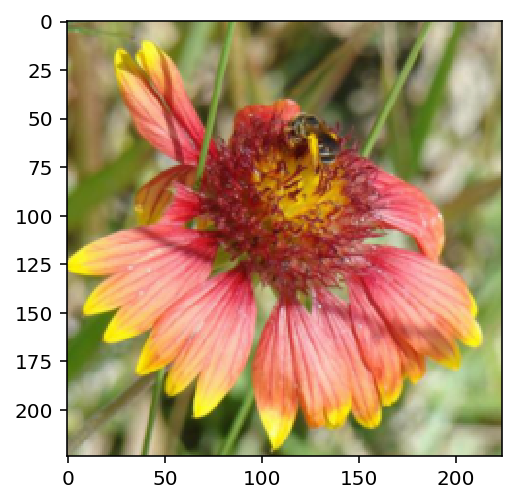

In [23]:
image_pth = 'flowers/test/100/image_07902.jpg'
img = process_image(image_pth)
imshow(img);

## 类别预测

可以获得格式正确的图像后 

要获得前 $K$ 个值，在张量中使用 [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk)。该函数会返回前 `k` 个概率和对应的类别索引。你需要使用  `class_to_idx`（希望你将其添加到了模型中）将这些索引转换为实际类别标签，或者从用来加载数据的[ `ImageFolder`](https://pytorch.org/docs/master/torchvision/datasets.html?highlight=imagefolder#torchvision.datasets.ImageFolder)进行转换。确保颠倒字典

同样，此方法应该接受图像路径和模型检查点，并返回概率和类别。

In [24]:
# probs, classes = predict(image_path, model)
# print(probs)
# print(classes)
# > [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
# > ['70', '3', '45', '62', '55']

In [75]:
def predict(device, image_pth, model, topk=5):

    model.eval()
    model.to(device)
    
    image = process_image(image_pth) # Tensor
    model_input = image.unsqueeze(0)
    output = model(model_input.to(device))
    output_probs = F.softmax(output, dim=1)#将交叉熵输出归一化
    top_probs, top_labels = output_probs.topk(topk)

    top_probs = top_probs.cpu().detach().numpy().tolist()[0] 
    top_labels = top_labels.cpu().detach().numpy().tolist()[0]
  
    index_to_class = {model.class_to_idx[k]: k for k in model.class_to_idx}
    chosen_classes = []
    for label in top_labels:
        chosen_classes.append(index_to_class[label])
    
    return top_probs, chosen_classes

In [26]:
top_probs, chosen_classes = predict(device, 'flowers/test/100/image_07902.jpg',model,topk=5)
display(top_probs)
display(chosen_classes)

[0.3505255877971649,
 0.18244045972824097,
 0.1473161280155182,
 0.10659061372280121,
 0.04320355877280235]

['100', '40', '46', '38', '84']

## 检查运行状况

你已经可以使用训练的模型做出预测，现在检查模型的性能如何。即使测试准确率很高，始终有必要检查是否存在明显的错误。使用 `matplotlib` 将前 5 个类别的概率以及输入图像绘制为条形图，应该如下所示：

<img src='assets/inference_example.png' width=300px>

你可以使用 `cat_to_name.json` 文件（应该之前已经在 notebook 中加载该文件）将类别整数编码转换为实际花卉名称。要将 PyTorch 张量显示为图像，请使用定义如下的 `imshow` 函数。

In [29]:
# TODO: Display an image along with the top 5 classes
def display_predict(image_pth):
    # 设置图像大小
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # 设置图像名称
    flower_num = image_pth.split('/')[2]
    title = cat_to_name[flower_num]
    #显示输入的图像
    img = process_image(image_pth)
    imshow(img, ax, title)
    
    # 进行预测
    probs, classes = predict(device, image_pth, model, topk=5) 
    flower_name = []
    for class_idx in classes:
        flower_name.append(cat_to_name[class_idx])
    # 画出概率分布
    plt.subplot(2,1,2)
    sb.barplot(x=probs, y=flower_name, color=sb.color_palette()[0])
    
    plt.show()

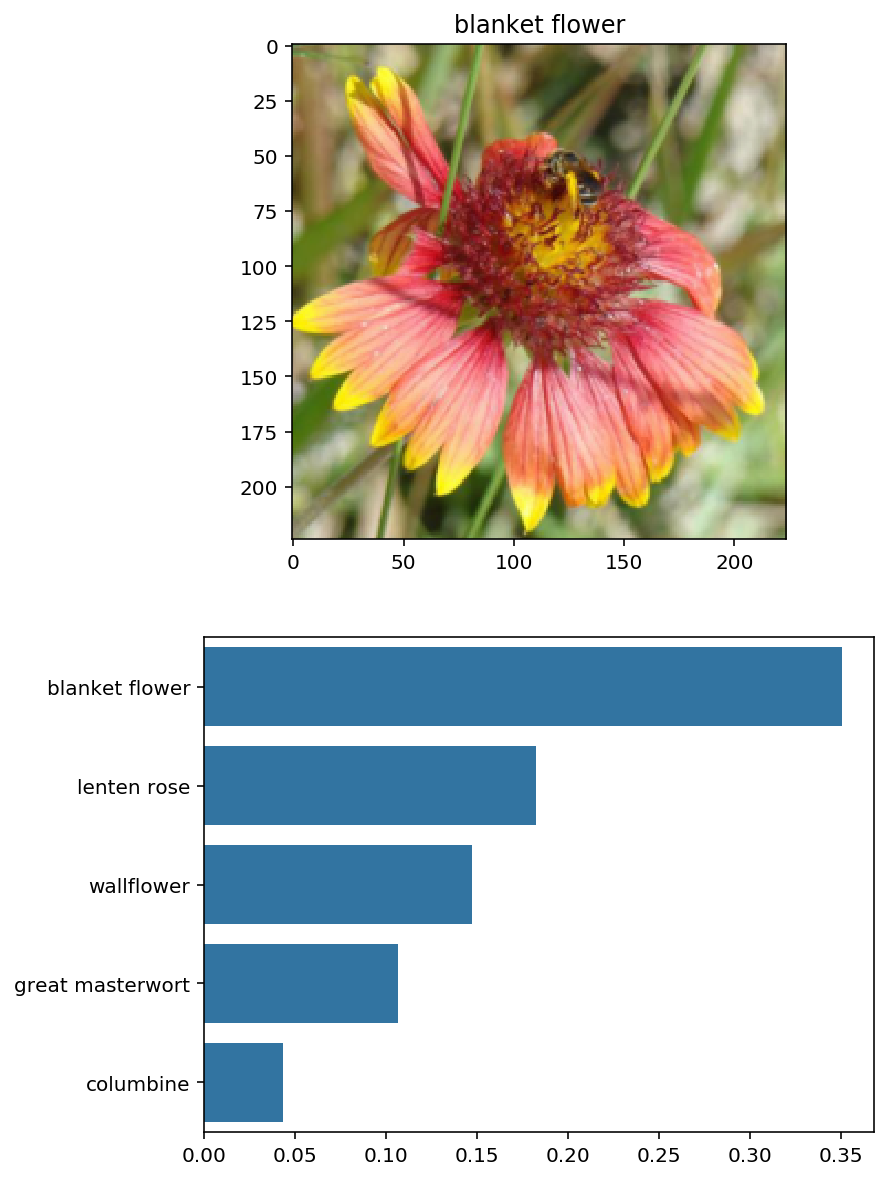

In [30]:
image_path = 'flowers/test/100/image_07902.jpg'
display_predict(image_path)

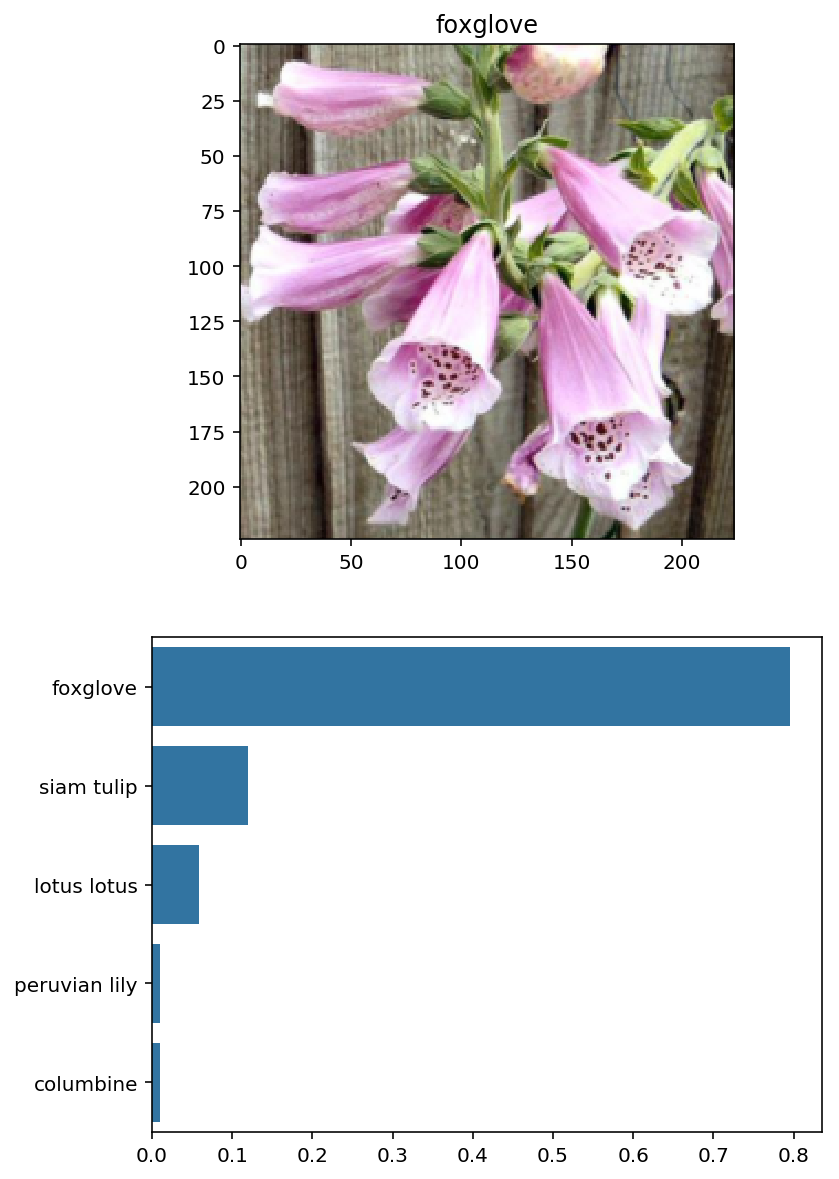

In [31]:
image_path = 'flowers/test/94/image_07399.jpg' 
display_predict(image_path)